In [1]:
##Libraries##

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import insert
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import bccr
from bccr import PW
from bccr import SW
import lxml
from bs4 import BeautifulSoup



In [21]:
##Connection to cmv_uat database##

server = 'tcp:mycmvserver.database.windows.net' 
database = 'cmvdb_uat' 
username = 'ecervantes@cmvlatam.com' 
password = 'Columbia87/' 


connection = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};Server=tcp:mycmvserver.database.windows.net,1433;Database=cmvdb_uat;Uid='+username+';Pwd='+password+';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;Authentication=ActiveDirectoryInteractive')
cursor = connection.cursor()

In [22]:
ncliente =  112859 ##Blotter + last 5 trades ### 
query = "SELECT * FROM [dbo].[fxblotter.t]"
# Read the SQL query into a DataFrame
fxblotter = pd.read_sql(query, connection, index_col='tradeid', parse_dates=True)
fxblotter.sort_index(inplace=True)
#datetime format#
fxblotter['tradedate'] = pd.to_datetime(fxblotter['tradedate'])
fxblotter['valuedate'] = pd.to_datetime(fxblotter['valuedate'])
## filtro para numero de cliente en T o dia de consulta ###
fxblottert = fxblotter.loc[fxblotter['clienteid'] == ncliente]
## filtro para accionid, escencialmente deja los Lost deals por fuera del calculo ##
fxblottert = fxblottert[fxblottert['accionid'] == 1] ### acepting 'addnew', 'lost' do not count for spread analysis##

query = "SELECT * FROM [dbo].[cstats]"
# Read the SQL query into a DataFrame
cstatsblotter = pd.read_sql(query, connection, index_col='tradeid', parse_dates=True)
cstatsblotter.sort_index(inplace=True)
#datetime format#
cstatsblotter['tradedate'] = pd.to_datetime(fxblotter['tradedate'])
cstatsblotter['valuedate'] = pd.to_datetime(fxblotter['valuedate'])
## filtro para numero de cliente en T o dia de consulta ###
cstatsblottert = cstatsblotter.loc[cstatsblotter['clienteid'] == ncliente]
ccstatsblottert = cstatsblottert.copy() ## to solve chained assigement error
#won/lost format#
ccstatsblottert.loc[ccstatsblottert['accionid'] == 1, 'accionid'] = 'won'
ccstatsblottert.loc[ccstatsblottert['accionid'] == 4, 'accionid'] = 'lost'
ccstatsblottert.tail(5)

##fxblottert.head(5)

,descliente,tradedate,accionid,side,px_sp,px_cover,monex_pxlast,monex_pp,ejecutivo,comccy,montocom,venccy,montoven,valuedate,dealer,clienteid
tradeid,,,,,,,,,,,,,,,,
202103100001409,RUIZ CASTRO VICTOR MANUEL,2021-03-10,won,Bid,610.0,610.90,610.90,610.90,JCARV,USD,3000.00,CRC,1830000.00,2021-03-10,Esteban Cervantes,112859
202104090001048,RUIZ CASTRO VICTOR MANUEL,2021-04-09,won,Bid,610.0,614.15,614.15,614.15,JCARV,USD,1639.34,CRC,999997.40,2021-04-09,Esteban Cervantes,112859
202105180000602,RUIZ CASTRO VICTOR MANUEL,2021-05-18,won,Bid,613.0,617.99,617.99,617.99,JCARV,USD,1360.70,CRC,834109.10,2021-05-18,Esteban Cervantes,112859
202106140000278,RUIZ CASTRO VICTOR MANUEL,2021-06-14,won,Bid,615.0,617.76,617.76,617.76,JCARV,USD,3252.03,CRC,1999998.45,2021-06-14,Esteban Cervantes,112859
202106290003848,RUIZ CASTRO VICTOR MANUEL,2021-06-29,won,Bid,616.0,618.75,619.15,618.99,JCARV,USD,1623.38,CRC,1000002.08,2021-06-29,Esteban Cervantes,112859


In [24]:
px_bid_cover = 621.00       ##internal price split--
px_ask_cover = 622.00 
ventbid = '616.00'
ventask = '625.00'

In [26]:
## RFQ ## Must run C-Stats firt ##
##ccstatsblottert.info()
##Market Data##
##Static Market Data##
#monex_pxlast = '620.20'       ##last traded price in Monex--
#monex_pp = '620.50'           ##last update weighted average Monex--
##Live Market Data##
monexpxlast = float(1*SW(3435).iloc[-1])
monexpp = float(1*SW(3439).iloc[-1])



bidpxpp = monexpp - spreadbidmpp3p
bidpxcover = px_bid_cover - spreadbidpxc3p
bidpxlast = monexpxlast - spreadbidpxl3p

askpxpp = monexpp + spreadaskmpp3p
askpxcover = px_ask_cover + spreadaskpxc3p
askpxlast = monexpxlast + spreadaskpxl3p

bidpx = (bidpxpp*0.40)+(bidpxcover*0.35)+(bidpxlast*0.25)
askpx = (askpxpp*0.40)+(askpxcover*0.35)+(askpxlast*0.25)

print1 ="Bid:  {:,}  |  Ask:  {:,}             | Beta Version 1.0 " 
print(print1.format(round(bidpx,3),round(askpx,3)))

##meter intervalos de confianza que dependan de la std del spread 


Bid:  618.208  |  Ask:  622.123             | Beta Version 1.0 


                                         
Bid Spread to Monex P.P :  CRC 3.979 | 3.58 CRC Last 3P
Bid Spread to Cover P.P :  CRC 3.957 | 3.5 CRC Last 3P
Bid Spread to Monex last traded PX :  CRC 3.994 | 3.633 CRC Last 3P
                                         
Bid monto promedio por transaccion :  2,095.242 USD
Bid total millage :  23,048.0 USD
Bids traded :  11 
                                         
************************************************************************************
                                         
Ask Spread to Monex P.P :  CRC nan | 0 CRC Last 3P
Ask Spread to Cover P.P :  CRC nan | 0 CRC Last 3P
Ask Spread to Monex last traded PX : CRC nan | 0 CRC Last 3P
                                         
Bid monto promedio por transaccion :  nan USD
Ask total millage :  0.0 USD
Asks :  0
                                         
************************************************************************************
                                         
Frid

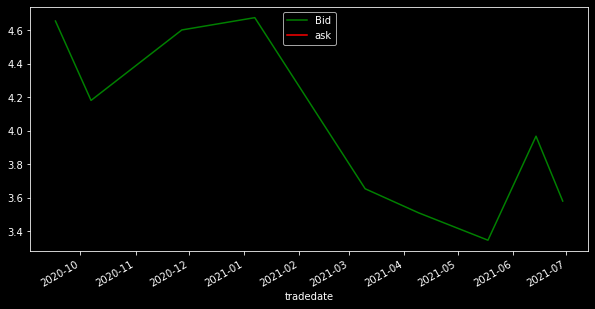

In [25]:
### C-Stats
#info ya viene con filtro por cliente
#Filtro el blotter por bid y ask y creo dos dataframe separados
#bid
bidfxblotter = fxblottert.loc[fxblottert['comccyid'] == 1 ]
bidblotter = bidfxblotter.copy() ## to solve chained assigement error
bidblotter = bidblotter.set_index('tradedate')
#ask
askfxblotter = fxblottert.loc[fxblottert['venccyid'] == 1 ] 
askblotter = askfxblotter.copy() ## to solve chained assigement error
askblotter = askblotter.set_index('tradedate')

# Q de trades
bidcount = fxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].count()
askcount = fxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].count()

#Calculo de Spreads ITD
bidblotter['spreadbidmpp'] =  bidblotter['monex_pp'] - bidblotter['px_sp'] #diff contra Monex PP
bidblotter['spreadbidpxc'] =  bidblotter['px_cover'] - bidblotter['px_sp'] #diff contra Cover
bidblotter['spreadbidpxl'] =  bidblotter['monex_pxlast'] - bidblotter['px_sp'] #diff contra ultimo de Monex
spreadbidmpp =  bidblotter['spreadbidmpp'].mean()
spreadbidpxc =  bidblotter['spreadbidpxc'].mean()
spreadbidpxl =  bidblotter['spreadbidpxl'].mean()
askblotter['spreadaskmpp'] =  askblotter['px_sp'] - askblotter['monex_pp'] #diff contra Monex PP
askblotter['spreadaskpxc'] =  askblotter['px_sp'] - askblotter['px_cover'] #diff contra Cover
askblotter['spreadaskpxl'] =  askblotter['px_sp'] - askblotter['monex_pxlast'] #diff contra ultimo de Monex
spreadaskmpp =  askblotter['spreadaskmpp'].mean()
spreadaskpxc =  askblotter['spreadaskpxc'].mean()
spreadaskpxl =  askblotter['spreadaskpxl'].mean()

#Calculo de Spreads 3 last pitches
if bidcount == 0:
    spreadbidmpp3p = 0
    spreadbidpxc3p = 0
    spreadbidpxl3p = 0
else:
    spreadbidmpp3p =  bidblotter['spreadbidmpp'].rolling(window=3).mean().iloc[-1]
    spreadbidpxc3p =  bidblotter['spreadbidpxc'].rolling(window=3).mean().iloc[-1]
    spreadbidpxl3p =  bidblotter['spreadbidpxl'].rolling(window=3).mean().iloc[-1]
if askcount == 0:
    spreadaskmpp3p = 0
    spreadaskpxc3p = 0
    spreadaskpxl3p = 0
else:
    spreadaskmpp3p =  askblotter['spreadaskmpp'].rolling(window=3).mean().iloc[-1]
    spreadaskpxc3p =  askblotter['spreadaskpxc'].rolling(window=3).mean().iloc[-1]
    spreadaskpxl3p =  askblotter['spreadaskpxl'].rolling(window=3).mean().iloc[-1]



# Monto promedio por ticket
bidmontoavg =  bidblotter.loc[bidblotter['comccyid'] == 1, 'montocom'].mean()
askmontoavg = askblotter.loc[askblotter['venccyid'] == 1, 'montoven'].mean( )
# Millage total del cliente
bidsum = fxblottert.loc[fxblotter['comccyid'] == 1, 'montocom'].sum()
asksum = fxblottert.loc[fxblotter['venccyid'] == 1, 'montoven'].sum()
##blendedspread = 

#sumo todos los colones y todos los dolares, y calculo los dolares a tasa de cover 

##print(bidblotter['spreadbidmpp'].rolling(window=3).mean().tail(1))
print("                                         ")
print1 ="Bid Spread to Monex P.P :  CRC {:,} | {:,} CRC Last 3P"
print(print1.format(round(spreadbidmpp,3),round(spreadbidmpp3p,3)))
print1 ="Bid Spread to Cover P.P :  CRC {:,} | {:,} CRC Last 3P"
print(print1.format(round(spreadbidpxc,3),round(spreadbidpxc3p,3)))
print1 ="Bid Spread to Monex last traded PX :  CRC {:,} | {:,} CRC Last 3P"
print(print1.format(round(spreadbidpxl,3),round(spreadbidpxl3p,3)))
print1 ="Bid monto promedio por transaccion :  {:,} USD"
print("                                         ")
print(print1.format(round(bidmontoavg,3)))
print1 ="Bid total millage :  {:,} USD"
print(print1.format(round(bidsum,0)))
print1 ="Bids traded :  {:,} "
print(print1.format(bidcount))
print("                                         ")
print("************************************************************************************")
print("                                         ")
print1 ="Ask Spread to Monex P.P :  CRC {:,} | {:,} CRC Last 3P"
print(print1.format(round(spreadaskmpp,3),round(spreadaskmpp3p,3)))
print1 ="Ask Spread to Cover P.P :  CRC {:,} | {:,} CRC Last 3P"
print(print1.format(round(spreadaskpxc,3),round(spreadaskpxc3p,3)))
print1 ="Ask Spread to Monex last traded PX : CRC {:,} | {:,} CRC Last 3P"
print(print1.format(round(spreadaskpxl,3),round(spreadaskpxl3p,3)))
print("                                         ")
print1 ="Bid monto promedio por transaccion :  {:,} USD"
print(print1.format(round(askmontoavg,3)))
print1 ="Ask total millage :  {:,} USD"
print(print1.format(round(asksum,0)))
print1 ="Asks :  {:,}"
print(print1.format(askcount))
print("                                         ")
print("************************************************************************************")
print("                                         ")
print(fxblottert['tradedate'].dt.day_name().value_counts())

#graphs and visuals

bidrolling = bidblotter['spreadbidmpp'].rolling(window=3).mean()
askrolling = askblotter['spreadaskmpp'].rolling(window=3).mean()

#fig, (ax1, ax2) = plt.subplots()
plt.style.use('dark_background')
bidrolling.plot( color='green', label="Bid", figsize=(10,5)) 
askrolling.plot(color='red', label="ask", figsize=(10,5))
ax = plt.gca()
ax.legend(loc='upper center')
##ax.patch.set_facecolor('blue')
##ax.set_axis_bgcolor('blue')
#ax.set_xlabel(fontcolor='red')
#ax1.set_xlabel(bidblotter['tradedate']) 
#ax2.set_xlabel(askblotter['spreadaskmpp'])  

##  = plt.subplots(,askblotter['spreadaskmpp'].rolling(window=3).mean())

#bidrolling.plot.line( label = "spread",xlabel = "tradedate 3Day Rolling Spread")
#askrolling.plot.line( label = "spread",xlabel = "tradedate 3Day Rolling Spread")
##Agregar Histograma para este ultimo print
##fxblottert['tradedate'].dt.day_name().value_counts().hist(bins = day_name())